In [1]:
import rdkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import mbuild as mb
import parmed
import torch
from torch import nn
import torch_geometric as tg
from torch_geometric.loader import DataLoader
import torch.utils.data
import shutil
import sys
import rdkit 
sys.path.insert(1, '~/egnn_cof/models/egnn_clean')
sys.path.insert(1, '~/egnn_cof')
# from easydict import EasyDict as edict
import torch
from torch import nn, optim
# My imports
from loader import *
from megnn import *
from utils import *

try:
    shutil.rmtree('./processed')
except:
    pass

/Users/kieran/multi-egnn/loader.py:331: DeprecationWarning: invalid escape sequence \p
  enviro = [ row['PDI'], row['Mw(Da)'], row['\phi'], row['w'] ]


In [15]:
device = torch.device("cpu")
dtype = torch.float32
df = pd.read_excel('./cloud_point.xlsx')
df = df.drop_duplicates().dropna()
dat = Cloud_Point_Dataset(root='.',dataframe=df)

batch_size = 16
loader = DataLoader(dat, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)

model = MEGNN(n_graphs=2, in_node_nf=7, in_edge_nf=0, hidden_nf=64, device=device, n_layers=7, coords_weight=1.0,
             attention=True, node_attr=1, n_enviro=4)
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)

In [9]:
model.eval()
preds = []
truths = []
for data in loader:  # Iterate in batches over the training dataset.
    dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
    dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
    batch_size_s, n_nodes_s, _ = dense_positions_s.size()
    batch_size_t, n_nodes_t, _ = dense_positions_t.size()
    atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
    atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)
    edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_s *= diag_mask
    edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
    edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_t *= diag_mask
    edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)
    atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
    atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)
    one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
    one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
    one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
    one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
    edges_s = get_adj_matrix(n_nodes_s, batch_size_s, device)
    edges_t = get_adj_matrix(n_nodes_t, batch_size_t, device)
    enviro = data.enviro.to(device, dtype)
    label = data.y.to(device, dtype)
    
    pred = model(h0=[one_hot_s, one_hot_t], x=[atom_positions_s, atom_positions_t], all_edges=[edges_s, edges_t],
                        all_edge_attr=[None, None], node_masks=[atom_mask_s, atom_mask_t],
                        edge_masks=[edge_mask_s, edge_mask_t], n_nodes=[n_nodes_s, n_nodes_t], enviro = enviro)
    preds.extend(list(pred.detach()))
    truths.extend(list(label))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x4 and 7x64)

Text(0, 0.5, 'Predicted')

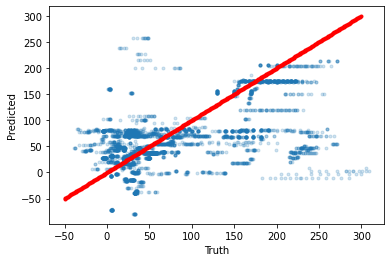

In [24]:
plt.plot(truths, preds,'.',alpha=.2)
plt.plot(list(range(-50,300)), list(range(-50,300)), 'r.')
plt.xlabel('Truth')
plt.ylabel('Predicted')

In [10]:
for d in loader:
    print(d)

PairDataBatch(edge_index_s=[2, 256], x_s=[256, 4], x_s_batch=[256], x_s_ptr=[17], positions_s=[256, 3], positions_s_batch=[256], positions_s_ptr=[17], n_nodes_s=[16], edge_index_t=[2, 93], x_t=[109, 4], x_t_batch=[109], x_t_ptr=[17], positions_t=[109, 3], positions_t_batch=[109], positions_t_ptr=[17], n_nodes_t=[16], enviro=[16, 4], y=[16], batch=[16], ptr=[17])
PairDataBatch(edge_index_s=[2, 256], x_s=[256, 4], x_s_batch=[256], x_s_ptr=[17], positions_s=[256, 3], positions_s_batch=[256], positions_s_ptr=[17], n_nodes_s=[16], edge_index_t=[2, 100], x_t=[116, 4], x_t_batch=[116], x_t_ptr=[17], positions_t=[116, 3], positions_t_batch=[116], positions_t_ptr=[17], n_nodes_t=[16], enviro=[16, 4], y=[16], batch=[16], ptr=[17])
PairDataBatch(edge_index_s=[2, 256], x_s=[256, 4], x_s_batch=[256], x_s_ptr=[17], positions_s=[256, 3], positions_s_batch=[256], positions_s_ptr=[17], n_nodes_s=[16], edge_index_t=[2, 76], x_t=[92, 4], x_t_batch=[92], x_t_ptr=[17], positions_t=[92, 3], positions_t_batc

In [21]:
dat.dataframe.loc[dat.dataframe['Polymer'] == 'polystyrene-d8']

Polymer Polymer CAS  \
0    polystyrene-d8  27732-42-9   
1    polystyrene-d8  27732-42-9   
2    polystyrene-d8  27732-42-9   
3    polystyrene-d8  27732-42-9   
4    polystyrene-d8  27732-42-9   
..              ...         ...   
390  polystyrene-d8  27732-42-9   
391  polystyrene-d8  27732-42-9   
392  polystyrene-d8  27732-42-9   
393  polystyrene-d8  27732-42-9   
394  polystyrene-d8  27732-42-9   

                                        Polymer SMILES  \
0    [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   
1    [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   
2    [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   
3    [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   
4    [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   
..                                                 ...   
390  [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   
391  [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   
392  [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   
393  [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   
394  [2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...   

                                 Solvent Solvent CAS  \
0                            nitroethane     79-24-3   
1                            nitroethane     79-24-3   
2                            nitroethane     79-24-3   
3                          propionitrile    107-12-0   
4                            nitroethane     79-24-3   
..                                   ...         ...   
390                          nitroethane     79-24-3   
391                        propionitrile    107-12-0   
392  1,1,1,3,3,3-hexadeutero-2-propanone    666-52-4   
393                          nitroethane     79-24-3   
394                          nitroethane     79-24-3   

                              Solvent SMILES  Mw(Da)   PDI     \phi       w  \
0                             CC[N+](=O)[O-]   27200  1.03  0.12780  0.1202   
1                             CC[N+](=O)[O-]   27200  1.03  0.17425  0.1644   
2                             CC[N+](=O)[O-]   27200  1.03  0.19746  0.1866   
3                                      CCC#N   26700  1.05  0.09173  0.1100   
4                             CC[N+](=O)[O-]   85200  1.02  0.11958  0.1124   
..                                       ...     ...   ...      ...     ...   
390                           CC[N+](=O)[O-]   27200  1.03  0.22404  0.2121   
391                                    CCC#N   26700  1.05  0.19629  0.2301   
392  [2H]C([2H])([2H])C(=O)C([2H])([2H])[2H]   26900  1.06  0.16818  0.1850   
393                           CC[N+](=O)[O-]   85200  1.02  0.10595  0.0995   
394                           CC[N+](=O)[O-]   27200  1.03  0.09315  0.0874   

     P(MPa)  CP (C)   1-Phase                             ref  
0      4.73   -3.97  positive  doi.org/10.1006/jcht.1999.0607  
1      4.44   -4.08  positive  doi.org/10.1006/jcht.1999.0607  
2      0.48   -3.87  positive  doi.org/10.1006/jcht.1999.0607  
3      2.28  172.28  negative       doi.org/10.1021/ma9517308  
4      0.25   14.99  positive  doi.org/10.1006/jcht.1999.0607  
..      ...     ...       ...                             ...  
390    5.11   -4.47  positive  doi.org/10.1006/jcht.1999.0607  
391    0.66  158.55  negative       doi.org/10.1021/ma9517308  
392    3.02   90.37  negative     doi.org/10.1021/ma00107a011  
393    0.56   14.96  positive  doi.org/10.1006/jcht.1999.0607  
394    1.65   -4.31  positive  doi.org/10.1006/jcht.1999.0607  

[395 rows x 14 columns]